# Optimal data packet routing path for aeronautical networks 

**Author: David Cuellar** <br>
*s5535743@bournemouth.ac.uk* <br>
*Dept. Computing & Informatics* <br>
*Bournemouth University* <br>

**Search and Optimization** <br>
*Professor Jiankang Zhang Ph.D.*

### Abstract

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

### Introduction

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

### Literature Review

#### literature
Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

#### literature
Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

#### literature
Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

### Methodology

#### Data importing and fixing

To work with the data, it was first necessary to follow the following steps:
1. Import the data: When analyzing the first and last 5 data it is observed that there are 216 data, that all are at the same Timestamp and that their coordinates are in polar system.

2. Add the two Ground Stations (GS) in the last two rows of the dataframe.

3. Create a function to change the polar coordinates (Altitude, Latitude, Longitude) to Cartesian coordinates (Px, Py, Pz).

4. Create a new dataframe with polar and Cartesian coordinates (df_res).

5. Plot the data Px, Py, Pz of each Node. Differentiate with blue circles the aircraft and with red Xs the GS: Analyze the graph and with this you can make assumptions of how some results will look like (like some aircraft are close to the GS and others will not have routes since they are far away from any GS).

6. Calculate the Euclidean distance between each node. Matrix of n x n (In this case 218 x 218).

7. Create a Transmition Rate matrix and make a matrix (tr_df) of the relationship between each Euclidean distance and the Transmition Rate matrix.

In [1]:
#####----------------------------------------#####
#---- Data importing and fixing: Step 1      ----#
#####----------------------------------------#####

#Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import math 
import time
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import scipy.spatial.distance as dist

#Read data
datapath = "data.csv"
df = pd.read_csv(datapath)

#Show data
df

,Flight No.,Timestamp,Altitude,Latitude,Longitude
0,AA101,1530277200,39000.0,50.9,-38.7
1,AA109,1530277200,33000.0,60.3,-12.2
2,AA111,1530277200,39000.0,52.7,-18.1
3,AA113,1530277200,37000.0,43.0,-11.1
4,AA151,1530277200,36400.0,47.0,-27.7
...,...,...,...,...,...
211,UA971,1530277200,32000.0,60.9,-29.9
212,UA973,1530277200,33000.0,61.0,-39.3
213,UA975,1530277200,36000.0,50.5,-26.4
214,UA986,1530277200,36000.0,60.0,-32.2


In [2]:
#####----------------------------------------#####
#---- Data importing and fixing: Step 2      ----#
#####----------------------------------------#####

#Create Ground Stations (GS)
LHR = {'Flight No.' : 'GS_LHR', 'Timestamp' : 1530277200, 'Altitude': 81.73, 'Latitude': 51.4700, 'Longitude': -0.4543}
EWR = {'Flight No.' : 'GS_EWR', 'Timestamp' : 1530277200, 'Altitude': 8.72, 'Latitude': 40.6895, 'Longitude': -74.1745}

#Append GS Airports to dataframe
df = df.append(LHR, ignore_index=True)
df = df.append(EWR, ignore_index=True)

In [3]:
#####----------------------------------------#####
#---- Data importing and fixing: Step 3      ----#
#####----------------------------------------#####

#Create constants
Re = 6371000 #Radius of the Earth (meters)
mf = 0.3048   #1 Foot = 0.3048 (meters)

#FUNCTION Polar Coordinates to Cartesian coordinates
def coordinates(obj):
    #Altitude (L), Latitude (theta), Longitude (psi)
    L = obj.Altitude
    theta = obj.Latitude
    psi = obj.Longitude
    
    #Functions for X (Px), Y(Py), Z(Pz)
    Px = (Re + L*mf)*math.cos(math.radians(theta))*math.cos(math.radians(psi))
    Py = (Re + L*mf)*math.cos(math.radians(theta))*math.sin(math.radians(psi))
    Pz = (Re + L*mf)*math.sin(math.radians(theta))
    return [Px, Py, Pz]



#####----------------------------------------#####
#---- Data importing and fixing: Step 4      ----#
#####----------------------------------------#####

#Create new temporal array result_pc and use coordinates function to fill 
#result_pc with every Cartesian coordinates
result_pc = []
for i in range(len(df)):
    t = coordinates(df.iloc[i])
    result_pc.append(t)

#Create temporal DataFrame df_pc with result_pc
df_pc = pd.DataFrame(result_pc, columns = ['Px', 'Py', 'Pz'])

#Append new columns to dataframe DF_RES
df_res = pd.concat([df , df_pc], axis="columns")
df_res

,Flight No.,Timestamp,Altitude,Latitude,Longitude,Px,Py,Pz
0,AA101,1530277200,39000.00,50.9000,-38.7000,3.141648e+06,-2.516935e+06,4.953417e+06
1,AA109,1530277200,33000.00,60.3000,-12.2000,3.090150e+06,-6.681141e+05,5.542788e+06
2,AA111,1530277200,39000.00,52.7000,-18.1000,3.676553e+06,-1.201683e+06,5.077417e+06
3,AA113,1530277200,37000.00,43.0000,-11.1000,4.580382e+06,-8.986352e+05,4.352703e+06
4,AA151,1530277200,36400.00,47.0000,-27.7000,3.853745e+06,-2.023261e+06,4.667569e+06
...,...,...,...,...,...,...,...,...
213,UA975,1530277200,36000.00,50.5000,-26.4000,3.636083e+06,-1.804967e+06,4.924487e+06
214,UA986,1530277200,36000.00,60.0000,-32.2000,2.700191e+06,-1.700401e+06,5.526951e+06
215,UA988,1530277200,36100.00,52.7000,-18.8000,3.661090e+06,-1.246337e+06,5.076714e+06
216,GS_LHR,1530277200,81.73,51.4700,-0.4543,3.968542e+06,-3.146735e+04,4.983939e+06


<IPython.core.display.Javascript object>


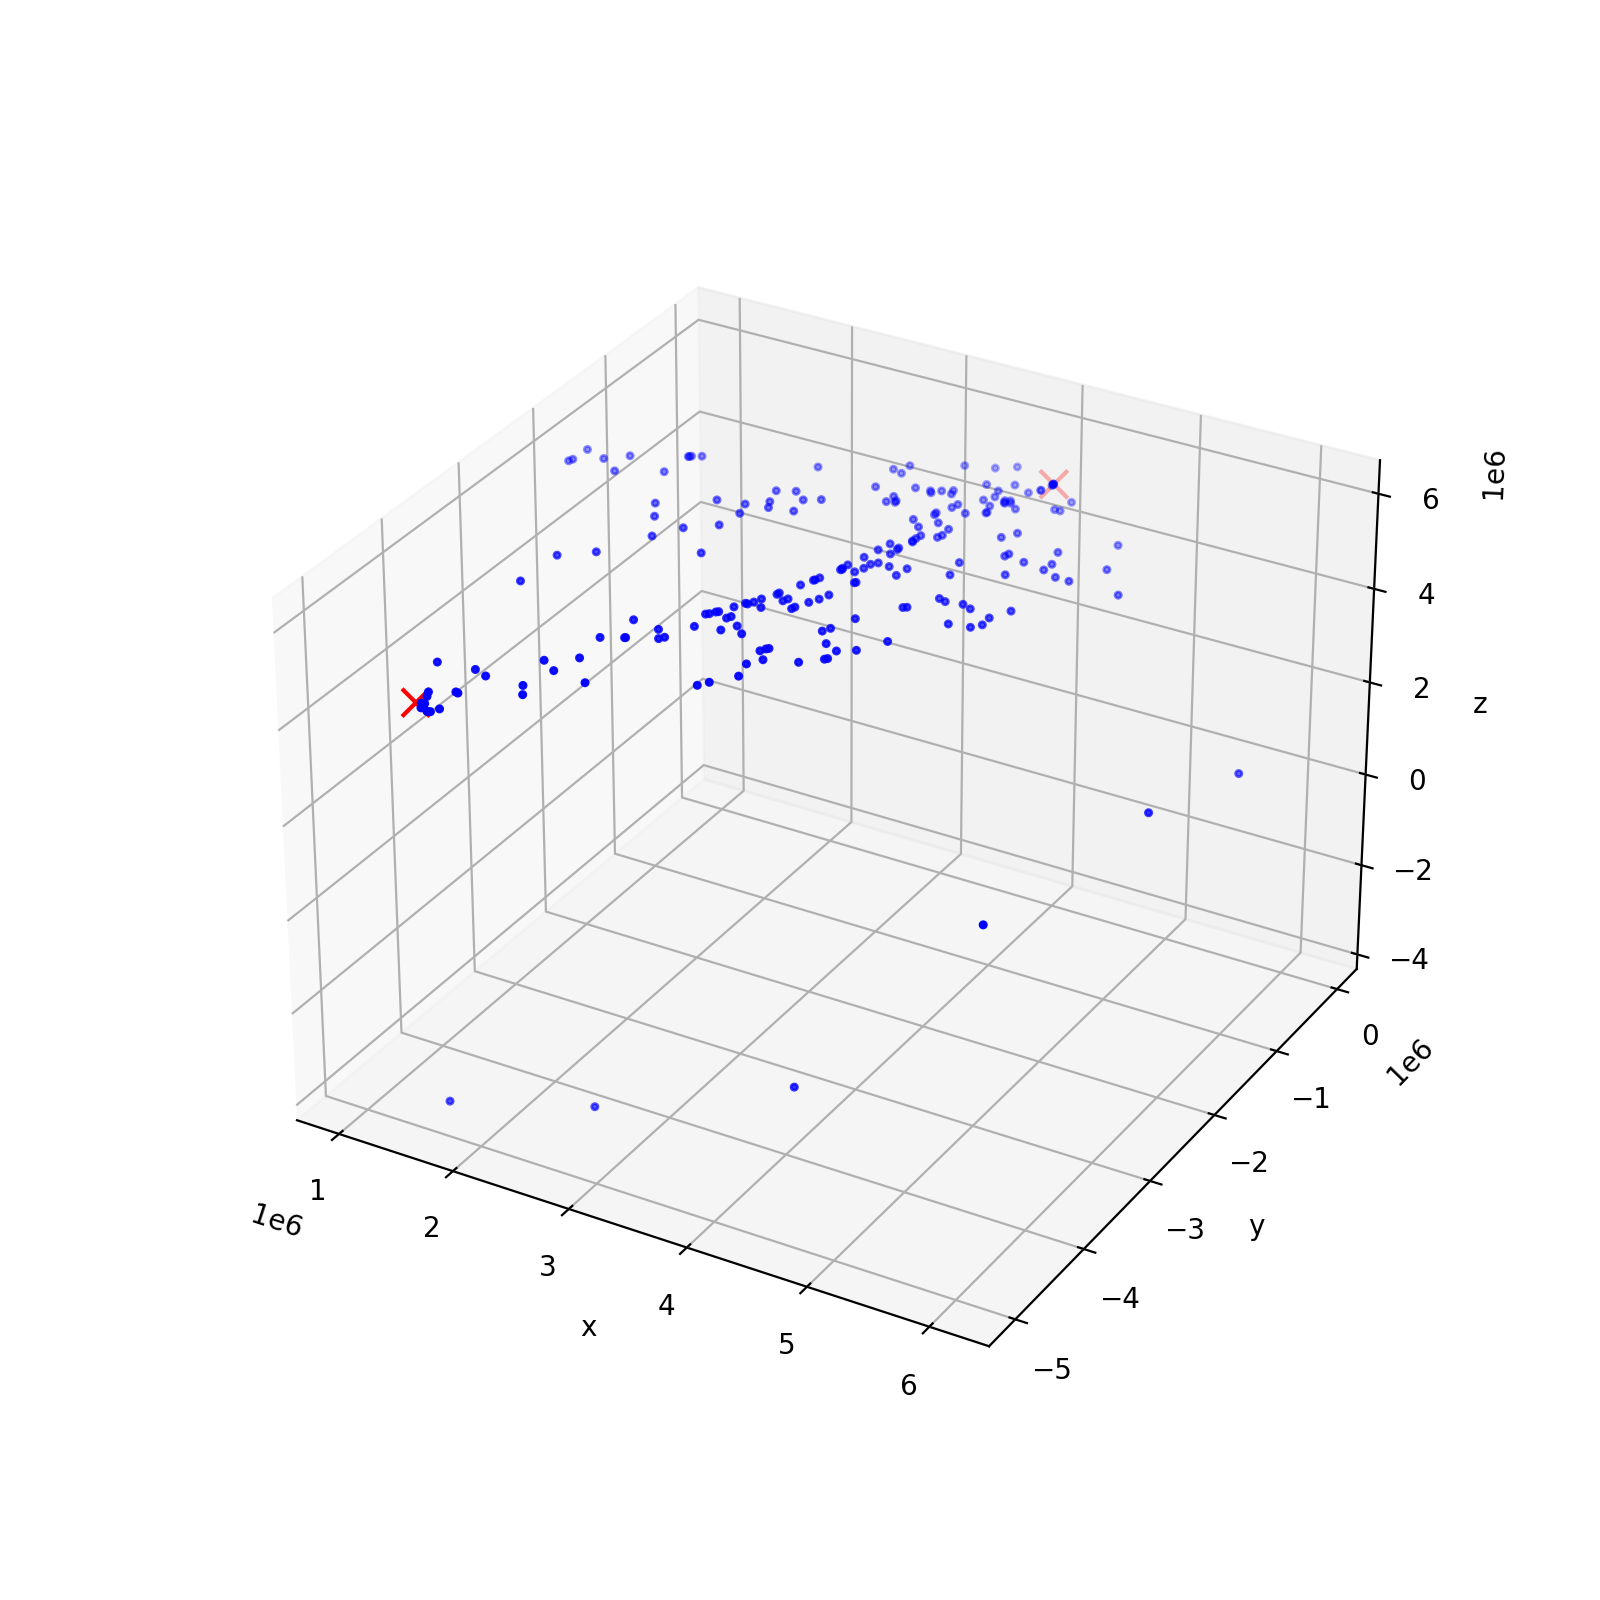

In [4]:
#####----------------------------------------#####
#---- Data importing and fixing: Step 5      ----#
#####----------------------------------------#####

#Plot ariplanes with 0 and GS with x
%matplotlib notebook

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(df_res['Px'][:216], df_res['Py'][:216],df_res['Pz'][:216], c='b', marker='o', s =5)
ax.scatter3D(df_res['Px'][216:218], df_res['Py'][216:218],df_res['Pz'][216:218], c='r', marker='x', s =100)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [5]:
#####----------------------------------------#####
#---- Data importing and fixing: Step 6      ----#
#####----------------------------------------#####

#Calculate euclidean distance in every node using scipy.spatial.distance as dist
distance_matrix = dist.squareform(dist.pdist(df_pc, 'euclidean'), force='no', checks=True)



#####----------------------------------------#####
#---- Data importing and fixing: Step 7      ----#
#####----------------------------------------#####

#Table transmition rate
tr = pd.DataFrame([['Red',    500000,  31.895], 
                   ['Orange', 400000,  43.505], 
                   ['Yellow', 300000,  52.857], 
                   ['Green',  190000,  63.970],
                   ['Blue',   90000,   77.071], 
                   ['Pink',   35000,   93.854],
                   ['Purple', 5560, 119.130]],
                   columns=['Mode_color', 'Switching_threshold', 'Transmission_rate'])
max_tr = 740000

#Create switch case to relate Switching_threshold to Transmission_rate
def switch_tr(dist):
    if dist > tr['Switching_threshold'][0] and dist <= max_tr:
        return tr['Transmission_rate'][0]
    elif dist > tr['Switching_threshold'][1] and dist <= tr['Switching_threshold'][0]:
        return tr['Transmission_rate'][1]
    elif dist > tr['Switching_threshold'][2] and dist <= tr['Switching_threshold'][1]:
        return tr['Transmission_rate'][2]
    elif dist > tr['Switching_threshold'][3] and dist <= tr['Switching_threshold'][2]:
        return tr['Transmission_rate'][3]
    elif dist > tr['Switching_threshold'][4] and dist <= tr['Switching_threshold'][3]:
        return tr['Transmission_rate'][4]
    elif dist > tr['Switching_threshold'][5] and dist <= tr['Switching_threshold'][4]:
        return tr['Transmission_rate'][5]
    elif dist > 0 and dist <= tr['Switching_threshold'][5]:
        return tr['Transmission_rate'][6]
    elif dist > max_tr or dist == 0:
        return 0

#Create function to change Switching_threshold to Transmission_rate
def tr_matrix(matrix):
    row_x = []
    column_x = []
    for row in range(0, matrix.shape[0]):
        column_x = []
        for column in range(0, matrix.shape[1]):
            column_x.append(switch_tr(matrix[row][column]))
        row_x.append(column_x)
    return row_x

#use tr_matrix function
tr_df = []
tr_df = tr_matrix(distance_matrix)
tr_df = np.array(tr_df)
tr_df

array([[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ..., 93.854,  0.   ,  0.   ],
       ...,
       [ 0.   ,  0.   , 93.854, ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ]])

## * * * Now data is ready and we will only work with the df_res column "Flight No." and with the tr_df matrix * * *

### Optimization solutions: Dijkstras Algorithm

Acá explico la variante de mi algoritmo, con las rows y tales

Hago la importación de el diagrama de flujo

![Dijkstras Flowchart](flowchart.jpg)

Adicionalmente pongo como se ve el resultado para cada source node

Example output: *[{'source': 'AA101',
  'routing path': [['UA15', 93.854],
   ['AA717', 77.071],
   ['AA57', 63.97],
   ['AA198', 31.895],
   ['GS_EWR', 77.071]],
  'End-to-end rate': 31.895},... ]*

In [15]:
#####----------------------------------------#####
#---- Functions                              ----#
#####----------------------------------------#####

#####----------------------------------------#####
#---- 1. Class Dijkstras: Evaluates longest  ----#
#---- routh path using transmition rate      ----#
#####----------------------------------------#####
class Dijkstras:
    #init function
    def __init__(self, data, tr_matrix):
        self.data = data
        self.tr_matrix = tr_matrix
    
    #longest transmition rate function
    #source = Airplane  --  target0 and target1 = Ground Station
    def longest_tr(self, source, target0, target1):
        #length matrix
        n = len(self.tr_matrix[source])
        
        #Create E2E Transimition rate 2D array (e2e_tr) and set all values with -inf
        e2e_tr = np.full(n, (-np.inf))  
        e2e_tr = np.array([e2e_tr],).tolist()
        
        #Create Previous Node 2D array (prev_node) and set all values with None (uses -1 as none)
        prev_node = np.full(n, -1)
        prev_node = np.array([prev_node],).tolist()

        #Create Visited 2D array (visited) and set all values with false (uses 0 as False)
        visited = np.full(n, 0)
        visited = np.array([visited],).tolist()
        
        #setea esto del source
        #First step change in Dijkstras Algorith is set source
        # e2e_tr in 0 and
        # visited as True
        e2e_tr[0][source] = 0
        visited[0][source] = 1
                
        forks = 1
        fork_row = 0
        
        fork_node = [source]
        
        #para validar tr
        fork_node_tr = [-np.inf]
        
        all_solutions = []
        solution_fork = []
        
        nodes_invalid_forks = [] #[from,to]
        
        max_e2e_tr_all = (-np.inf)
        
        #print('start')
                
        #Este while recorre todos los branches rows hacía abajo
        while fork_row < forks:
            #este es el nodo que se revisa actualmente
            node_now = fork_node[fork_row]
            
            found_gs = -1
            
            #print('f', fork_row, 'n', node_now)
            
            if [prev_node[fork_row][node_now],node_now] in nodes_invalid_forks or fork_node_tr[fork_row] < max_e2e_tr_all:
                fork_row = fork_row + 1
                
            
            else:
                
                #si nodo es diferente a targets recorra todo, si es igual, pase al siguiente fork.
                #a uno y al otro
                if node_now != target0 and node_now != target1:

                    #setea el maximo global en -inf, para verificar el máximo cerca
                    max_tr_int = (-np.inf)

                    #pare ver si hay más de un tr en este e2e
                    tot_max_tr_int = 0

                    #vamos a recorrer todos los E2E a ver cual es el mayor número, 
                    #pero solo de los visited = 0
                    #en la posición del nodo y branch que estemos
                    for idx, i in enumerate(e2e_tr[fork_row]):
                        if visited[fork_row][idx] == 0:
                            #si num en matriz mayor a cero y mayor al e2e cambielo 
                            #y cmabie prev_node al nodo de ahora
                            if (
                                self.tr_matrix[node_now][idx] > 0 and 
                                self.tr_matrix[node_now][idx] > e2e_tr[fork_row][idx]
                            ):
                                e2e_tr[fork_row][idx] = self.tr_matrix[node_now][idx]
                                prev_node[fork_row][idx] = node_now

                                if idx == target0 or idx == target1:
                                    found_gs = idx
                                
                                #encuentro el mayor tr int
                                if e2e_tr[fork_row][idx] > max_tr_int:
                                    max_tr_int = self.tr_matrix[node_now][idx]

                        
                    #para añadir los idx con e2e de los max encontrados
                    arr_temp_node_idx_max_tr_int = []

                    if found_gs != -1:
                        max_tr_int = e2e_tr[fork_row][found_gs]
                        arr_temp_node_idx_max_tr_int.append(found_gs)
                        tot_max_tr_int = 1

                    if found_gs == -1:    

                        #revisamos cuantos mayores hay para duplicar
                        for idx, i in enumerate(e2e_tr[fork_row]):
                            if visited[fork_row][idx] == 0 and e2e_tr[fork_row][idx] == max_tr_int:
                                tot_max_tr_int = tot_max_tr_int + 1
                                arr_temp_node_idx_max_tr_int.append(idx)

                    #si no hay max es que no hay con quien comparar, salgase del while
                    #porque está en ceros todo
                    if max_tr_int == -np.inf and forks == 1:
                        break
                        
                    #si el max encontrado es menor al global
                    # o si no encontró nada, salgase de ese fork
                    #siga siguiente fork si existe
                    if (
                        max_tr_int < max_e2e_tr_all or 
                        (max_tr_int == -np.inf and forks > 1)
                        ):

                        nodes_invalid_forks.append([prev_node[fork_row][node_now],node_now])
                        #print('invalid')

                        fork_row = fork_row + 1

                    if max_tr_int >= max_e2e_tr_all:     

                        #NO DUPLICADOS
                        #VUELVE VISISTED = 1
                        if tot_max_tr_int == 1:
                            visited[fork_row][arr_temp_node_idx_max_tr_int[0]] = 1
                 
                            fork_node[fork_row] = arr_temp_node_idx_max_tr_int[0]                            
                            fork_node_tr[fork_row] = max_tr_int
                                    

                        #---------
                        #---------
                        #Duplicados!!
                        #si hay más de un max e2t tr, creame otra row adicional
                        if tot_max_tr_int > 1  :
                            #print('si dup')
                            forks = forks + tot_max_tr_int - 1

                            #print('d:', tot_max_tr_int , 'fortkstotal:', forks)
                            #print('tr:', max_tr_int)
                            
                            for i in range(tot_max_tr_int):
                                visited[fork_row][arr_temp_node_idx_max_tr_int[i]] = 1

                            #creo una lista de n_max_int de cada uno, es decir e2e = [[0,0,0...],[0,0,0...]]
                            #es n_max_int - 1 porque ya tengo una row así, solo debo crear las faltantes
                            e2e_tr_temp = np.tile(e2e_tr[fork_row], (tot_max_tr_int - 1, 1)).tolist()
                            prev_node_temp = np.tile(prev_node[fork_row], (tot_max_tr_int - 1, 1)).tolist()
                            visited_temp = np.tile(visited[fork_row], (tot_max_tr_int - 1, 1)).tolist()

                            #añado duplicados de la que se debe duplicar a las matrices de cada uno
                            #es n_max_int - 1 porque ya tengo una row así, solo debo insertar las faltantes
                            #vuelvo visited = 1 diferente en cada nuevo row                        
                            for i in range(tot_max_tr_int - 1):
                                e2e_tr.append(e2e_tr_temp[i])
                                prev_node.append(prev_node_temp[i])
                                visited.append(visited_temp[i])

                            #for i in range(tot_max_tr_int):
                            #    visited[fork_row][arr_temp_node_idx_max_tr_int[i]] = 1

                            #for i in range(tot_max_tr_int - 1):
                            #    for j in range(tot_max_tr_int):
                            #        visited[len(visited)-1-i][arr_temp_node_idx_max_tr_int[j]] = 1


                            for i in range(tot_max_tr_int - 1):
                                #visited[len(visited)-1-i][arr_temp_node_idx_max_tr_int[i+1]] = 1
                                #fork_node[len(visited)-1-i] = arr_temp_node_idx_max_tr_int[i+1]
                                fork_node.append(arr_temp_node_idx_max_tr_int[i+1])
                                fork_node_tr.append(max_tr_int)

                            #visited[fork_row][arr_temp_node_idx_max_tr_int[0]] = 1
                            fork_node[fork_row] = arr_temp_node_idx_max_tr_int[0]                
                            fork_node_tr[fork_row] = max_tr_int

                #------------        
                #------------
                #acá es para GUARDAR E IMPRIMIR
                #this else is: if (fork_node[fork_row] == target0 or fork_node[fork_row] == target1):
                if node_now == target0 or node_now == target1:
                    #print('guardar')
                    
                    last_max_e2e_tr_all = max_e2e_tr_all
                    
                    route = print_node_route(E = e2e_tr[fork_row], 
                                             P = prev_node[fork_row], 
                                             V = visited[fork_row], 
                                             source = source, 
                                             target = fork_node[fork_row], 
                                             data = self.data)

                    min_E2E = min(np.array(route)[:,1].astype(float))
                    if min_E2E.astype(float) > max_e2e_tr_all:
                        max_e2e_tr_all = min_E2E.astype(float)
                    json = {"source": self.data[source], "routing path": route, "End-to-end rate": min_E2E }

                    #print(json)
                    #print('m',max_e2e_tr_all)
                    #print(max_e2e_tr_all == min_E2E)
                    
                    if max_e2e_tr_all == min_E2E:
                        all_solutions.append(json)
                        
                    fork_node_tr[fork_row] = min_E2E

                    fork_row = fork_row + 1
                
                    
                    #validar cuantos forks debo eliminar debido al max_e2e_tr_all mayor
                    if last_max_e2e_tr_all < max_e2e_tr_all:

                        i_idx = 0
                        while i_idx < len(fork_node_tr):
                            if fork_node_tr[i_idx] < max_e2e_tr_all:
                                e2e_tr_temp2 =  np.delete(e2e_tr, i_idx, 0)
                                prev_node_temp2 =  np.delete(prev_node, i_idx, 0)
                                visited_temp2 =  np.delete(visited, i_idx, 0)
                                fork_node_temp2 = np.delete(fork_node, i_idx)
                                fork_node_tr_temp2 = np.delete(fork_node_tr, i_idx)

                                e2e_tr = e2e_tr_temp2
                                prev_node = prev_node_temp2
                                visited = visited_temp2
                                fork_node = fork_node_temp2
                                fork_node_tr = fork_node_tr_temp2

                                forks = forks - 1
                                fork_row = fork_row -1
                            else:
                                i_idx = i_idx + 1

                        if fork_row < 0:
                            fork_row = 0

                        if type(e2e_tr) != list:
                            e2e_tr = e2e_tr.tolist()
                            prev_node = prev_node.tolist()
                            visited = visited.tolist()
                            fork_node = fork_node.tolist()
                            fork_node_tr = fork_node_tr.tolist()                    
            
            
            #return solutions
            solution_fork = max_e2e(solutions = all_solutions, 
                                e2e = max_e2e_tr_all)
        
            if len(solution_fork) >= 20 or len(all_solutions) > 500:
                #print("stops", len(solution_fork) >= 217 , len(all_solutions) > 500)
                break
        
        if len(solution_fork) == 0:
            solution_fork = {"source": self.data[source], "routing path": "No conection", "End-to-end rate": None }
        
        print('source:', source, 'branches:', fork_row, 'total:', forks, 'n solutions:', len(solution_fork))
        
        return solution_fork
        
#imprime la ruta
def print_node_route(E,P,V, source, target, data):
    #setea rp = routing path como el target, porque voy de atrás para adelante
    route_path = [[data[target],E[target]],]
    prev_node_route_path = P[target]

    print_nodes = True
    
    if (prev_node_route_path == source or prev_node_route_path == -1):
        print_nodes = False
        
    while(print_nodes):
        route_path.insert(0, [data[prev_node_route_path],E[prev_node_route_path]])
        prev_node_route_path = P[prev_node_route_path]        
        if (prev_node_route_path == source or prev_node_route_path == -1):
            print_nodes = False
    return route_path

#verificar cual es el mayor e2e y solo mostrar ese, VERIFICAR SI SE REPITEN, Y QUITARLOS
def max_e2e(solutions, e2e):
    #Check max E2D
    #result como matriz de todos los reusltados
    result = []
    #verificar cual es el mayor e2e y solo mostrar ese
    for i in range(len(solutions)):
        #print('entra')
        if solutions[i]['End-to-end rate'].astype(float) == e2e :
            result.append(solutions[i])
    #VERIFICAR SI SE REPITEN, Y QUITARLOS
    not_repeated = [i for n, i in enumerate(result) if i not in result[n + 1:]]
    return not_repeated

#Función testear nodo
def run_test_dijkstra(range_data, data, tr_matrix, target0, target1):
    solutions_json = []
    for i in range(0,range_data):
        solutions_json.append(Dijkstras(data = data, tr_matrix = tr_matrix).longest_tr(source = i, target0 = target0, target1 = target1))
    return solutions_json


### Experiments

Acá pongo al menos 3 imagenes de prueba, debo hacer los dibujos y hacer las importaciones de cada uno
1. Test 1: Single Output - From A5 to any Ground Station
![Test 1: Single example](SaO-Test1.jpg)


In [16]:
#Test1
data1 = np.array(['A1','A2','A3','A4','A5','A6','GS1','GS2'])

#                        [A1 ,A2 ,A3 ,A4 ,A5 ,A6 ,GS1,GS2]
tr_matrix1 = np.array((  [0  ,2.2,0.5,0  ,0.5,0  ,0  ,1.8],
                         [2.2,0  ,0  ,0.5,1.8,0  ,0  ,0  ],
                         [0.5,0  ,0  ,0.5,0  ,0.5,1.8,0  ],
                         [0  ,0.5,0.5,0  ,1.8,0  ,0  ,0  ],
                         [0.5,1.8,0  ,1.8,0  ,0  ,0  ,0  ],
                         [0  ,0  ,0.5,0  ,0  ,0  ,0  ,0  ],
                         [0  ,0  ,1.8,0  ,0  ,0  ,0  ,0  ],
                         [1.8,0  ,0  ,0  ,0  ,0  ,0  ,0  ]))

#source = 4 (A5) -- target0 = 6 (GS1) -- target1 = 7 (GS2)
Dijkstras(data = data1, 
          tr_matrix = tr_matrix1
         ).longest_tr(source = 4, 
                      target0 = 6, 
                      target1 = 7)   


source: 4 branches: 2 total: 2 n solutions: 1


[{'source': 'A5',
  'routing path': [['A2', 1.8], ['A1', 2.2], ['GS2', 1.8]],
  'End-to-end rate': 1.8}]

2. Test 2: Multiple outputs - From A5 to any Ground Station
![Test 2: Multiple outputs](SaO-Test2.jpg)


In [8]:
#Test2 -> A5-A2-A1-GS2 -> TR:1.8 ; A5-A4-A3-GS1 -> TR:1.8; A5-A4-A2-A1-GS2 -> TR:1.8
data2 = np.array(['A1','A2','A3','A4','A5','A6','GS1','GS2'])

#                        [A1 ,A2 ,A3 ,A4 ,A5 ,A6 ,GS1,GS2]
tr_matrix2 = np.array((  [0  ,2.2,0.5,0  ,0.5,0  ,0  ,1.8],
                         [2.2,0  ,0  ,1.8,1.8,0  ,0  ,0  ],
                         [0.5,0  ,0  ,1.8,0  ,0.5,1.8,0  ],
                         [0  ,1.8,1.8,0  ,1.8,0  ,0  ,0  ],
                         [0.5,1.8,0  ,1.8,0  ,0  ,0  ,0  ],
                         [0  ,0  ,0.5,0  ,0  ,0  ,0  ,0  ],
                         [0  ,0  ,1.8,0  ,0  ,0  ,0  ,0  ],
                         [1.8,0  ,0  ,0  ,0  ,0  ,0  ,0  ]))

#source = 4 (A5) -- target0 = 6 (GS1) -- target1 = 7 (GS2)
Dijkstras(data = data2, 
          tr_matrix = tr_matrix2
         ).longest_tr(source = 4, 
                      target0 = 6, 
                      target1 = 7)

source: 4 branches: 2 total: 2 n solutions: 2


[{'source': 'A5',
  'routing path': [['A2', 1.8], ['A1', 2.2], ['GS2', 1.8]],
  'End-to-end rate': 1.8},
 {'source': 'A5',
  'routing path': [['A4', 1.8], ['A3', 1.8], ['GS1', 1.8]],
  'End-to-end rate': 1.8}]

3. Test 3: All routes for every airplane
![Test 3: All routes](SaO-Test3.jpg)


In [9]:
#Test3 All routes
data3 = np.array(['A0','A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','GS1', 'GS2'])

#                        [A0 ,A1 ,A2 ,A3 ,A4 ,A5 ,A6 ,A7 ,A8 ,A9 ,A10,A11,A12,GS1,GS2]
tr_matrix3 = np.array((  [0  ,2  ,0  ,0  ,2  ,0  ,0  ,2  ,2  ,0  ,0  ,2  ,0  ,0  ,0  ],
                         [2  ,0  ,1  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ],
                         [0  ,1  ,0  ,0.5,0  ,1  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ],
                         [0  ,0  ,0.5,0  ,0  ,0  ,1  ,0  ,0  ,0  ,0  ,2  ,0  ,0  ,0  ],
                         [2  ,0  ,0  ,0  ,0  ,1  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ],
                         [0  ,0  ,1  ,0  ,1  ,0  ,1  ,1  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ],
                         [0  ,0  ,0  ,1  ,0  ,1  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ,1  ,0  ],
                         [2  ,0  ,0  ,0  ,0  ,1  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ],
                         [2  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ,1  ,1  ,0  ,0  ,0  ,0  ],
                         [0  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ,1  ,0  ,0  ,0  ,0  ,1  ,0  ],
                         [0  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ,1  ,0  ,0  ,0  ,0  ,0.5,0  ],
                         [2  ,0  ,0  ,2  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ],
                         [0  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ],
                         [0  ,0  ,0  ,0  ,0  ,0  ,1  ,0  ,0  ,1  ,0.5,0  ,0  ,0  ,0  ],
                         [0  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ,0  ],))

#source = all -- target0 = 13 (GS1) -- target1 = 14 (GS2)
run_test_dijkstra(len(data3)-2, 
                  data3, 
                  tr_matrix3, 
                  13, 
                  14)


source: 0 branches: 8 total: 8 n solutions: 5
source: 1 branches: 7 total: 7 n solutions: 5
source: 2 branches: 7 total: 7 n solutions: 1
source: 3 branches: 4 total: 4 n solutions: 1
source: 4 branches: 7 total: 7 n solutions: 3
source: 5 branches: 12 total: 12 n solutions: 4
source: 6 branches: 1 total: 1 n solutions: 1
source: 7 branches: 7 total: 7 n solutions: 3
source: 8 branches: 14 total: 14 n solutions: 5
source: 9 branches: 1 total: 1 n solutions: 1
source: 10 branches: 1 total: 1 n solutions: 1
source: 11 branches: 8 total: 8 n solutions: 5
source: 12 branches: 0 total: 1 n solutions: 3


[[{'source': 'A0',
   'routing path': [['A1', 2.0],
    ['A2', 1.0],
    ['A5', 1.0],
    ['A6', 1.0],
    ['GS1', 1.0]],
   'End-to-end rate': 1.0},
  {'source': 'A0',
   'routing path': [['A8', 2.0], ['A9', 1.0], ['GS1', 1.0]],
   'End-to-end rate': 1.0},
  {'source': 'A0',
   'routing path': [['A11', 2.0], ['A3', 2.0], ['A6', 1.0], ['GS1', 1.0]],
   'End-to-end rate': 1.0},
  {'source': 'A0',
   'routing path': [['A4', 2.0], ['A5', 1.0], ['A6', 1.0], ['GS1', 1.0]],
   'End-to-end rate': 1.0},
  {'source': 'A0',
   'routing path': [['A7', 2.0], ['A5', 1.0], ['A6', 1.0], ['GS1', 1.0]],
   'End-to-end rate': 1.0}],
 [{'source': 'A1',
   'routing path': [['A2', 1.0], ['A5', 1.0], ['A6', 1.0], ['GS1', 1.0]],
   'End-to-end rate': 1.0},
  {'source': 'A1',
   'routing path': [['A0', 2.0],
    ['A4', 2.0],
    ['A5', 1.0],
    ['A6', 1.0],
    ['GS1', 1.0]],
   'End-to-end rate': 1.0},
  {'source': 'A1',
   'routing path': [['A0', 2.0],
    ['A7', 2.0],
    ['A5', 1.0],
    ['A6', 1.0],
   

Pongo un experimento 3 experimentos reales:
1. Sin GS
2. Muy cerca al GS
3. Lejos del GS como la 0 que puede llegar a los dos aeropuertos

In [10]:
#No GS
#source = 64 (BA244) -- target0 = 216 (GS_LHR) -- target1 = 217 (GS_EWR)
Dijkstras(data = df.iloc[:, 0].to_numpy(), 
          tr_matrix = tr_df
         ).longest_tr(source = 64, 
                      target0 = 216, 
                      target1 = 217)

source: 64 branches: 0 total: 1 n solutions: 3


{'source': 'BA244', 'routing path': 'No conection', 'End-to-end rate': None}

In [11]:
#Close to GS
#source = 5 (AA198) -- target0 = 216 (GS_LHR) -- target1 = 217 (GS_EWR)
Dijkstras(data = df.iloc[:, 0].to_numpy(), 
          tr_matrix = tr_df
         ).longest_tr(source = 5, 
                      target0 = 216, 
                      target1 = 217)

source: 5 branches: 1 total: 1 n solutions: 1


[{'source': 'AA198',
  'routing path': [['GS_EWR', 77.071]],
  'End-to-end rate': 77.071}]

In [12]:
#Far away from GS
#source = 0 (AA101) -- target0 = 216 (GS_LHR) -- target1 = 217 (GS_EWR)
Dijkstras(data = df.iloc[:, 0].to_numpy(), 
          tr_matrix = tr_df
         ).longest_tr(source = 0, 
                      target0 =216, 
                      target1 =217)

source: 0 branches: 1244 total: 6233 n solutions: 20


[{'source': 'AA101',
  'routing path': [['UA15', 93.854],
   ['AA717', 77.071],
   ['DL49', 93.854],
   ['AA291', 63.97],
   ['AA57', 63.97],
   ['AA51', 63.97],
   ['UA56', 63.97],
   ['UA22', 77.071],
   ['BA117', 63.97],
   ['BA238', 63.97],
   ['UA123', 63.97],
   ['DL270', 77.071],
   ['AA198', 31.895],
   ['GS_EWR', 77.071]],
  'End-to-end rate': 31.895},
 {'source': 'AA101',
  'routing path': [['BA295', 63.97],
   ['BA185', 77.071],
   ['AA723', 77.071],
   ['BA173', 63.97],
   ['AA199', 63.97],
   ['AA53', 77.071],
   ['UA17', 77.071],
   ['AA111', 77.071],
   ['AA759', 77.071],
   ['DL31', 63.97],
   ['BA67', 77.071],
   ['AA39', 77.071],
   ['GS_LHR', 31.895]],
  'End-to-end rate': 31.895},
 {'source': 'AA101',
  'routing path': [['BA295', 63.97],
   ['BA185', 77.071],
   ['AA723', 77.071],
   ['BA173', 63.97],
   ['AA199', 63.97],
   ['AA53', 77.071],
   ['UA17', 77.071],
   ['AA111', 77.071],
   ['LH410', 63.97],
   ['BA2277', 63.97],
   ['UA908', 77.071],
   ['BA2271', 63.

### Evaluation

Recorro todos los nodos y hago:

1. Evaluación del tiempo que demora recorrer todos los gs.

2. Guardar en un archivo json los resultados

3. Debo mostrar algunos puntos en el mapa y como es su recorrido, unido por lineas (si se puede en mapa real mejor)

In [13]:

# get the start time
st = time.time()

#source = all -- target0 = 216 (GS_LHR) -- target1 = 217 (GS_EWR)
#evaluation = run_test_dijkstra(len(df.iloc[:, 0].to_numpy())-2, 
                               df.iloc[:, 0].to_numpy(), 
                               tr_df, 
                               216, 
                               217)

evaluation = run_test_dijkstra(2, df.iloc[:, 0].to_numpy(), tr_df, 216, 217)

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

with open("evaluation.txt", "w") as output:
    output.write(str(evaluation))

IndentationError: unexpected indent (86513597.py, line 6)

### Future research agenda

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

### Conclusions

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

### References

Lorem ipsum dolor sit amet <br>
Lorem ipsum dolor sit amet <br>
Lorem ipsum dolor sit amet <br>
Lorem ipsum dolor sit amet <br>